In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statistics
from statistics import mode
import sys
import aubio
import os
import wget

# Functions for extracting Audio Features

In [2]:
def beats_to_bpm(beats, path):
    # if enough beats are found, convert to periods then to bpm
    if len(beats) > 1:
        if len(beats) < 4:
            print("few beats found in {:s}".format(path))
        bpms = 60./np.diff(beats)
        return np.median(bpms)
    else:
        print("not enough beats")
        return 0

def extractAudioFeatures(path):
    samplerate, win_s, hop_s = 44100, 512, 256
    src = aubio.source(path, samplerate, hop_s)
    samplerate = src.samplerate
    hop_s = src.hop_size

    # Tempo vars
    tempo = aubio.tempo("specdiff", win_s, hop_s, samplerate)
    beats = []

    # Energy vars
    pv = aubio.pvoc(win_s, hop_s)
    f = aubio.filterbank(40, win_s)
    f.set_mel_coeffs_slaney(samplerate)
    energies = np.zeros((40,))

    # Pitch vars
    tolerance = 0.8
    pitch_o = aubio.pitch("yin", win_s, hop_s, samplerate)
    pitch_o.set_unit("midi")
    pitch_o.set_tolerance(tolerance)
    pitches = []

    # Note vars
    notes = []
    notes_o = aubio.notes("default", win_s, hop_s, samplerate)

    # Onset vars
    onset = aubio.onset("default", win_s, hop_s, samplerate)
    onsets = []

    # Do all audio extraction at once to save ~5x time
    total_frames = 0
    while True:
        samples, read = src()

        # Tempo
        is_beat = tempo(samples)
        if is_beat:
            this_beat = tempo.get_last_s()
            beats.append(this_beat)

        # Energies
        fftgrain = pv(samples)
        new_energies = f(fftgrain)
        energies = np.vstack([energies, new_energies])

        # Pitches
        pitch = pitch_o(samples)[0]
        pitches += [pitch]

        # Notes
        new_note = notes_o(samples)
        if (new_note[0] != 0):
            for n in new_note:
                if (n not in notes):
                    notes.append(n)

        # Onsets
        if onset(samples):
            onsets.append(onset.get_last())

        total_frames += read
        if read < hop_s: 
            break

    # Do a little more calculation on onsets
    diff = 0
    first = True
    last = 0
    cntr = 0
    for i in onsets:
        if (not first):
            diff += abs(i - last)
            cntr += 1
        first = False
        last = i

    if (cntr == 0): 
        onsetToReturn = 0
    else:
        onsetToReturn =  i / cntr

    # Return tuple of audio features we found
    return (beats_to_bpm(beats, path), np.mean(energies), (np.mean(pitches)), len(notes), onsetToReturn)

# Extract Data
***
## Read in Songs from Spotify API


In [3]:
# Connecting to spotify API using Spotipy
cid ="12b051049eb14a05ac3dd252770b6bd3" 
secret = "8844a8e5f63f4fa3998ba69811b2e005"

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
artist_name = []
track_name = []
popularity = []
track_id = []
genres = []
audio = []
filename = ''
os.makedirs(os.path.join(os.getcwd(), 'audioFiles'), exist_ok=True)
#changed to 300 for testing
#loading in 100 different tracks from 2010 with Spotipy
for i in range(0,1000,10):
    track_results = sp.search(q='year:2010', type='track', limit=10,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        # Only download audio data for songs with a preview url
        if(t['preview_url']):
            
            previewUrl = t['preview_url']
            name = t['name']
            name = name.replace('/', '')
            name = name.replace(':', '')
            
            try:
                # Download preview of audio file from Spotify
                filepath = os.path.join(os.getcwd(), 'audioFiles', name + '.mp3')
                
                # Only download if it does not already exist
                if not os.path.isfile(filepath):
                    filename = wget.download(previewUrl, out=filepath)
                else:
                    filename = filepath

                # Populating lists we will use for DF later
                artist_name.append(t['artists'][0]['name'])
                track_name.append(t['name'])
                track_id.append(t['id'])
                popularity.append(t['popularity'])
                artist = sp.artist(t["artists"][0]["external_urls"]["spotify"])
                genres.append(artist["genres"]) 
                audio.append(filename)

            except Exception as e:
                pass
            
print(f"Found all required information for {len(audio)} songs")            

Found all required information for 752 songs


In [5]:
# Storing data in dataframe
df_tracks = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'popularity':popularity})
df_tracks.head()

,artist_name,track_name,track_id,popularity
0,Bruno Mars,Talking to the Moon,161DnLWsx1i3u1JT05lzqU,84
1,Waylon Jennings,The Year 2003 Minus 25 - Remastered,0sFq478LIo9BFwf2qzMzzF,44
2,Mac Miller,The Spins,51pshtuYkgUQnt5huMPbKL,79
3,Anthem Lights,Best of 2010: Baby / Break Even / Need You Now...,5J1iMCE9SnuOqwRwOpVxhp,43
4,Roar,I Can't Handle Change,0I1eFRytp4XRhLCjT6tZm7,81


# Extract Audio Features

## Spotify Audio Features

In [6]:
rows = []
batchsize = 100

# Create list of audio features for each song
for i in range(0,len(df_tracks['track_id']),batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t != None:
            rows.append(t)


In [7]:
# Storing audio feature data of each song in a dataframe
df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
print("Shape of the dataset:", df_audio_features.shape)
df_audio_features.head()

Shape of the dataset: (752, 18)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.523,0.606,1,-4.754,0,0.0301,0.5120,0.000000,0.1060,0.065,145.837,audio_features,161DnLWsx1i3u1JT05lzqU,spotify:track:161DnLWsx1i3u1JT05lzqU,https://api.spotify.com/v1/tracks/161DnLWsx1i3...,https://api.spotify.com/v1/audio-analysis/161D...,217867,4
1,0.626,0.457,4,-13.785,1,0.0384,0.3550,0.000009,0.0668,0.474,102.166,audio_features,0sFq478LIo9BFwf2qzMzzF,spotify:track:0sFq478LIo9BFwf2qzMzzF,https://api.spotify.com/v1/tracks/0sFq478LIo9B...,https://api.spotify.com/v1/audio-analysis/0sFq...,184267,4
2,0.794,0.766,9,-3.894,0,0.0377,0.0135,0.000000,0.0785,0.550,127.007,audio_features,51pshtuYkgUQnt5huMPbKL,spotify:track:51pshtuYkgUQnt5huMPbKL,https://api.spotify.com/v1/tracks/51pshtuYkgUQ...,https://api.spotify.com/v1/audio-analysis/51ps...,195873,4
3,0.417,0.443,5,-6.261,1,0.0328,0.7090,0.000000,0.2170,0.470,119.903,audio_features,5J1iMCE9SnuOqwRwOpVxhp,spotify:track:5J1iMCE9SnuOqwRwOpVxhp,https://api.spotify.com/v1/tracks/5J1iMCE9SnuO...,https://api.spotify.com/v1/audio-analysis/5J1i...,155342,4
4,0.247,0.438,5,-8.479,1,0.0358,0.0455,0.000871,0.1110,0.390,185.716,audio_features,0I1eFRytp4XRhLCjT6tZm7,spotify:track:0I1eFRytp4XRhLCjT6tZm7,https://api.spotify.com/v1/tracks/0I1eFRytp4XR...,https://api.spotify.com/v1/audio-analysis/0I1e...,198213,3


## Aubio Audio Features

In [8]:
tempo=[]
energy=[]
pitch=[]
onset=[]
notes=[]
n = len(audio)
print(f"Found {n} songs to extract audio features from")
i = 1
for song in audio:
    # Status indicator, roughly every ~10%
    if i % int(n / 10) == 0:
        print(f"Processed {i} songs")
    i += 1
    
    audioFeatures = extractAudioFeatures(song)
    tempo.append(audioFeatures[0])
    energy.append(audioFeatures[1])
    pitch.append(audioFeatures[2])
    notes.append(audioFeatures[3])
    onset.append(audioFeatures[4])

Found 752 songs to extract audio features from
Processed 75 songs
Processed 150 songs
Processed 225 songs
Processed 300 songs
Processed 375 songs
Processed 450 songs
Processed 525 songs
Processed 600 songs
Processed 675 songs
Processed 750 songs


In [9]:
df_aubio_features = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'tempo':tempo,'energy':energy,'pitch':pitch,'onset':onset, 'notes':notes})
df_aubio_features.head()

752
752
752
752
752


,artist_name,track_name,tempo,energy,pitch,onset,notes
0,Bruno Mars,Talking to the Moon,147.904103,0.068742,65.028557,14525.314607,45
1,Waylon Jennings,The Year 2003 Minus 25 - Remastered,102.478727,0.025345,64.017937,8872.243243,43
2,Mac Miller,The Spins,128.048716,0.056839,72.513550,8894.885135,47
3,Anthem Lights,Best of 2010: Baby / Break Even / Need You Now...,122.932462,0.064571,70.766594,13841.430108,44
4,Roar,I Can't Handle Change,125.474279,0.043150,69.930077,27582.914894,36


# Normalize Onset + Pitch to match Spotify Dataset

We will keep tempo unstandardized to match as well.

In [33]:
column = 'onset'
df_aubio_features[column] = (df_aubio_features[column] - df_aubio_features[column].min()) / (df_aubio_features[column].max() - df_aubio_features[column].min())    
column = 'pitch'
df_aubio_features[column] = (df_aubio_features[column] - df_aubio_features[column].min()) / (df_aubio_features[column].max() - df_aubio_features[column].min())    
column = 'notes'
df_aubio_features[column] = (df_aubio_features[column] - df_aubio_features[column].min()) / (df_aubio_features[column].max() - df_aubio_features[column].min())    
df_aubio_features.head()

,artist_name,track_name,tempo,energy,pitch,onset,notes
0,Bruno Mars,Talking to the Moon,147.904103,0.068742,0.576326,0.064473,0.575342
1,Waylon Jennings,The Year 2003 Minus 25 - Remastered,102.478727,0.025345,0.559284,0.039381,0.547945
2,Mac Miller,The Spins,128.048716,0.056839,0.702548,0.039481,0.602740
3,Anthem Lights,Best of 2010: Baby / Break Even / Need You Now...,122.932462,0.064571,0.673089,0.061437,0.561644
4,Roar,I Can't Handle Change,125.474279,0.043150,0.658982,0.122431,0.452055


# Create GMM 

In [39]:
# EM algo to create GMMs
def EM(dat, k, n):
    
    p_class=np.zeros(k)
    means=np.zeros((k,n))
    covars=np.zeros((k,n,n))
    mean_dist=np.array(0)
    p_data_given_class=np.zeros((len(dat),k))

    
    # Initializations
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    
    for dim in range(k):
        covars[dim,:,:]=np.cov(np.transpose(dat))
        means[dim,:]=dat.iloc[init_idx[dim]]
        p_class[dim]=1/k
    for step in range(50):  
        # Bayes stuff: pdfs then pdf*mixtures, then normalize
        for dim in range(k):
            p_data_given_class[:,dim]=  np.array([stats.multivariate_normal.pdf(x=dat, mean=means[dim,:], cov=covars[dim,:,:], allow_singular=True)])
        p_class_given_data=p_data_given_class*p_class

        sums=np.sum(p_class_given_data, axis=1)
        for dim in range(k):
            p_class_given_data[:,dim]=p_class_given_data[:,dim]*(1/sums)
        n_class = np.sum(p_class_given_data, axis=0)
        p_class=n_class/len(dat)

        # Mean and covar updates
        for dim in range(k):
            for f1 in range(n):
                means[dim,f1]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,f1])*(1/n_class[dim])
                
                for f2 in range(n):
                    if (f1==f2):
                        covars[dim,f1,f2]=np.sum(p_class_given_data[:,dim]*((dat.iloc[:,f1]-means[dim,f1])**2))*(1/n_class[dim])
                    else:
                        covars[dim,f1,f2]=np.sum(p_class_given_data[:,dim]*(dat.iloc[:,f1]-means[dim,f1])*(dat.iloc[:,f2]-means[dim,f2]))*(1/n_class[dim])                                                           
    mean_dist=0
    
    for pt in range(len(dat)):
        for dim in range(k):
            # For each datum-mean pair, compute their prob-weighted distance apart
            mean_dist+=np.sqrt(np.sum((means[dim,:]-np.array(dat.iloc[pt]))**2)*p_class_given_data[pt,dim])
    mean_dist=mean_dist/(len(dat)*k)
    return p_class, means, covars, mean_dist, p_class_given_data

## Create GMM for k=2,4,6,8,10 clusters for Spotify Data

In [40]:
# Create the GMMs with various K values to find the best K value to use
test_df = df_audio_features[['acousticness', 'energy', 'tempo', 'liveness', 'valence']]

p2, m2, c2, d2, pc2 = EM(test_df, 2, 5)
p4, m4, c4, d4, pc4 = EM(test_df, 4, 5)
p6, m6, c6, d6, pc6  = EM(test_df, 6, 5)
p8, m8, c8, d8, pc8  = EM(test_df, 8, 5)
p10, m10, c10, d10, pc10  = EM(test_df, 10, 5)

## Create GMM for k=2,4,6,8,10 clusters for Aubio Data

In [41]:
test_df_aubio_features = df_aubio_features[['notes', 'tempo', 'energy', 'pitch', 'onset']]

ap2, am2, ac2, ad2, apc2 = EM(test_df_aubio_features, 2, 5)
ap4, am4, ac4, ad4, apc4 = EM(test_df_aubio_features, 4, 5)
ap6, am6, ac6, ad6, apc6  = EM(test_df_aubio_features, 6, 5)
ap8, am8, ac8, ad8, apc8  = EM(test_df_aubio_features, 8, 5)
ap10, am10, ac10, ad10, apc10  = EM(test_df_aubio_features, 10, 5)

## Decide which k value is the best to use

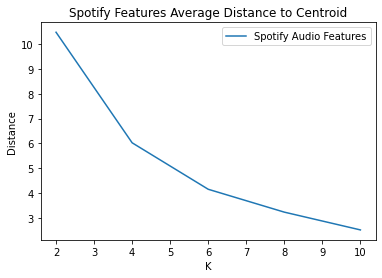

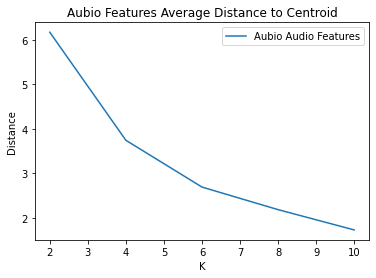

In [43]:
plt.plot([2,4,6,8, 10], [d2,d4,d6,d8, d10], label = "Spotify Audio Features")
plt.title('Spotify Features Average Distance to Centroid');
plt.xlabel("K")
plt.ylabel("Distance")
plt.legend()
plt.show()

plt.plot([2,4,6,8, 10], [ad2,ad4,ad6,ad8, ad10], label = "Aubio Audio Features")
plt.title('Aubio Features Average Distance to Centroid');
plt.xlabel("K")
plt.ylabel("Distance")
plt.legend()
plt.show()

Using 6 Audio features, it appers the k=4 is the best k value to use.

## Create clusters for Spotify GMM

In [44]:
spotify_clusters = []
for pt in pc4:
    max_prob = max(pt)
    spotify_clusters.append(np.where(pt ==  max_prob)[0][0])

## Create clusters for Aubio GMM

In [45]:
aubio_clusters = []
for apt in apc4:
    max_prob = max(apt)
    aubio_clusters.append(np.where(apt ==  max_prob)[0][0])

# Use PCA to find the two most related dimensions for our plot - Spotify

In [46]:
# PCA to find the two most related dimensions to plot
M = pd.DataFrame(test_df).values
MT = np.transpose(M)
MTM = np.matmul(MT, M)

# Decomposition of given data matrix
evals, evecs = np.linalg.eig(MTM)
np.sum(evecs[:,0]**2)
evals_sorted =  np.flip(np.sort(evals),0)

# Get the sorted list of indices for the eigenvalues
idx_sorted = [list(evals).index(ee) for ee in evals_sorted]
E = evecs[:,idx_sorted]

# Rotated M by E
spotify_ME2 = np.matmul(M, E[:,:2])

In [47]:
s_x = []
s_y = []
for i in range(spotify_ME2.shape[0]):
    s_x.append(spotify_ME2[i,0])
    s_y.append(spotify_ME2[i,1]) 

# Use PCA to find the two most related dimensions for our plot - Aubio

In [48]:
# PCA to find the two most related dimensions to plot
M = pd.DataFrame(test_df_aubio_features).values
MT = np.transpose(M)
MTM = np.matmul(MT, M)

# Decomposition of given data matrix
evals, evecs = np.linalg.eig(MTM)
np.sum(evecs[:,0]**2)
evals_sorted =  np.flip(np.sort(evals),0)

# Get the sorted list of indices for the eigenvalues
idx_sorted = [list(evals).index(ee) for ee in evals_sorted]
E = evecs[:,idx_sorted]

#Rotated M by E
aubio_ME2 = np.matmul(M, E[:,:2])

In [49]:
a_x = []
a_y = []
for i in range(aubio_ME2.shape[0]):
    a_x.append(aubio_ME2[i,0])
    a_y.append(aubio_ME2[i,1]) 

## Plot our clusters

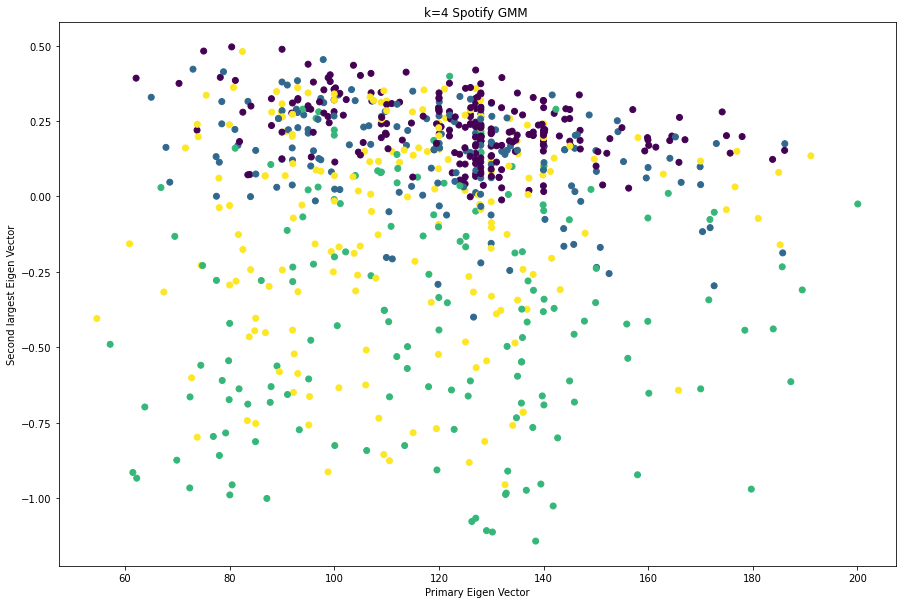

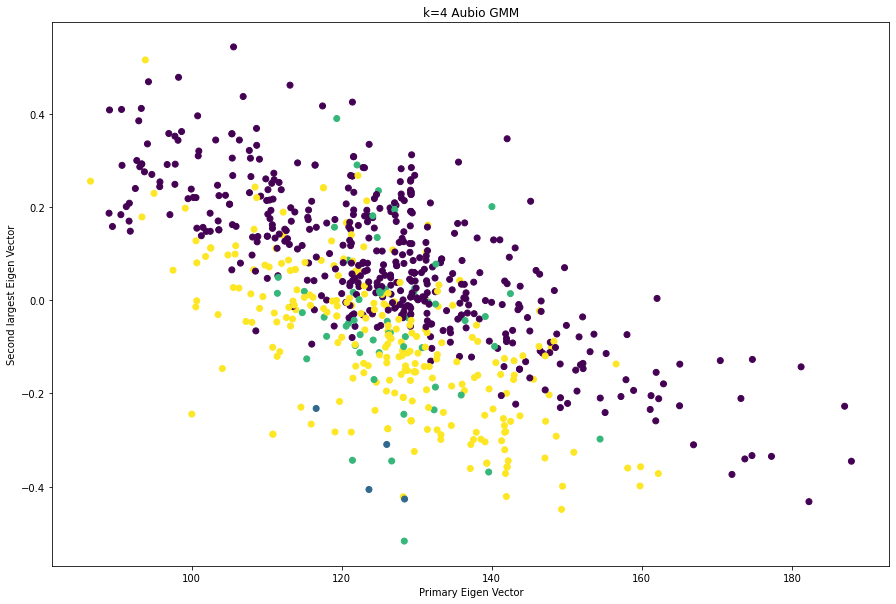

In [51]:
# Plot the clusters using the two most related dimensions
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('k=4 Spotify GMM ')
ax.scatter(s_x,s_y, c=spotify_clusters)
ax.set_xlabel('Primary Eigen Vector')
ax.set_ylabel('Second largest Eigen Vector')


fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('k=4 Aubio GMM')
ax.scatter(a_x,a_y, c=aubio_clusters)
ax.set_xlabel('Primary Eigen Vector')
ax.set_ylabel('Second largest Eigen Vector')
plt.show()

# Find the most common genres from each cluster accoridng to Spotify

In [52]:
# Print all the songs in the first cluster
index = 0
c1_genre = []
c2_genre = []
c3_genre = []
c4_genre = []
for song in spotify_clusters:
    if(song == 0):
        c1_genre.append(genres[index])
    if(song == 1):
        c2_genre.append(genres[index])
    if(song == 2):
        c3_genre.append(genres[index])
    if(song == 3):
        c4_genre.append(genres[index])
    index = index+1


In [53]:
c1_flat = [x for sublist in c1_genre for x in sublist]
c2_flat = [x for sublist in c2_genre for x in sublist]
c3_flat = [x for sublist in c3_genre for x in sublist]
c4_flat = [x for sublist in c4_genre for x in sublist]

In [54]:
def get_popular_genres(n, data):
    
    df=pd.DataFrame(data = {'Number': data})
    df1 = pd.DataFrame(df['Number'].value_counts())
    return  df1['Number'].index[:n,]

print("Cluster 1 most common genres: ",  get_popular_genres(4, c1_flat).values)
print("Cluster 2 most common genres: ",  get_popular_genres(4, c2_flat).values)
print("Cluster 3 most common genres: ",  get_popular_genres(4, c3_flat).values)
print("Cluster 4 most common genres: ",  get_popular_genres(4, c4_flat).values)

Cluster 1 most common genres:  ['pop punk' 'rock' 'emo' 'dance pop']
Cluster 2 most common genres:  ['dance pop' 'pop' 'rock' 'album rock']
Cluster 3 most common genres:  ['contemporary country' 'country' 'country road' 'pop']
Cluster 4 most common genres:  ['country rock' 'rock' 'dance pop' 'pop']


# Get the probabilty a new song belong to each cluster

## Gather 10 new songs

In [ ]:
artist_name = []
track_name = []
popularity = []
track_id = []
genres = []

# Loading in 10 different tracks from 2021 with Spotipy
for i in range(10):
    track_results = sp.search(q='year:2020', type='track', limit=1,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        #populating lists we will use for DF later
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
        artist = sp.artist(t["artists"][0]["external_urls"]["spotify"])
        genres.append(artist["genres"]) 

In [ ]:
# Storing data in dataframe
df_new_tracks = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'popularity':popularity})

In [ ]:
df_new_tracks.head()

In [ ]:
rows = []
batchsize = 10

# Create list of audio features for each song
for i in range(0,len(df_new_tracks['track_id']),batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t != None:
            rows.append(t)

## Extract Audio Featureds

In [ ]:
# Storing audio feature data of each song in a dataframe
df_new_audio_features = pd.DataFrame.from_dict(rows,orient='columns')


In [ ]:
new_test_df = df_new_audio_features[['acousticness', 'energy', 'tempo',  'liveness', 'valence']]
new_testt_df.head()

## Get the probability a song belongs to each cluster

In [ ]:
# Method to compute the probabilty a new song belongs to each genre (cluster)
def p_class_given_data(song, k, means, covars, p_class):
    p_song_given_cluster = []
    p_cluster_given_song = []
    for cluster in range(k):
        p_song_given_cluster.append( stats.multivariate_normal.pdf(x=song, mean=means[cluster], cov=covars[cluster]))
        p_cluster_given_song.append( p_song_given_cluster[cluster] * p_class[cluster] )
    
    summ = sum(p_cluster_given_song)
    
    for cluster in range(k):
        p_cluster_given_song[cluster] = p_cluster_given_song[cluster] / summ
    
    return  p_cluster_given_song

In [ ]:
for index in range(10):
    song = list(new_test_df.iloc[index].values)
    probs = p_class_given_data(song, 4, m4, c4, p4)


    print("probability of belonging to cluster 0 with genres", get_popular_genres(4, c1_flat).values, ":", probs[0].round(4))
    print("probability of belonging to cluster 1 with genres", get_popular_genres(4, c2_flat).values, ":", probs[1].round(4))
    print("probability of belonging to cluster 2 with genres", get_popular_genres(4, c3_flat).values, ":", probs[2].round(4))
    print("probability of belonging to cluster 3 with genres", get_popular_genres(4, c4_flat).values, ":", probs[3].round(4))
    print("")
    
    
    
    #todo 
#     probs = p_class_given_data(song, 4, am4, ac4, ap4)
# see if the probabilities are the same

    